In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
import matplotlib as mpl

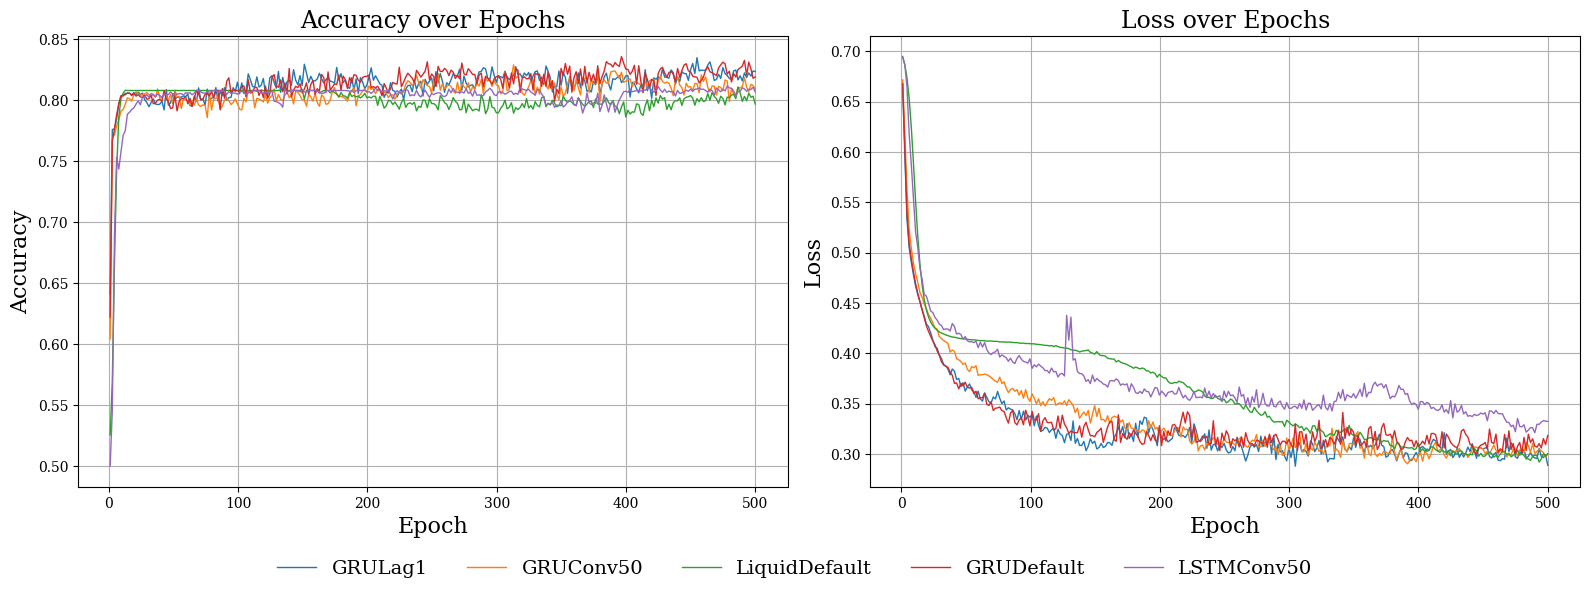

In [2]:
def extract_metrics_from_file(file_path):
    all_epochs = []
    all_accuracy = []
    all_loss = []
    all_auc = []
    
    with open(file_path, 'r') as f:
        for line in f:
            match = re.match(r"Epoch (\d+): ACC = ([\d\.]+) std: ([\d\.]+); LOSS = ([\d\.]+) std: ([\d\.]+); AUC = ([\d\.]+) std: ([\d\.]+)", line)
            if match:
                epoch, acc, acc_std, loss, loss_std, auc, auc_std = match.groups()
                all_epochs.append(int(epoch))
                all_accuracy.append(float(acc))
                all_loss.append(float(loss))
                all_auc.append(float(auc))
    
    return all_epochs, all_accuracy, all_loss, all_auc

def smooth_curve(x, y, num_points=300):
    """Returns a B-spline smoothed curve."""
    if len(x) < 4:
        return x, y
    x_new = np.linspace(min(x), max(x), num_points)
    spline = make_interp_spline(x, y, k=3)
    y_new = spline(x_new)
    return x_new, y_new

def smooth_curve(x, y, num_points=300):
    if len(x) < 4:
        return x, y
    x_new = np.linspace(min(x), max(x), num_points)
    spline = make_interp_spline(x, y, k=3)
    y_new = spline(x_new)
    return x_new, y_new

def plot_metrics(
    log_folder,
    read_file,
    model_prefix,
    model_suffix,
    save_path=None,
    smooth=True,
    use_latex=False,
    legend_cols=4,
    legend_adjust=0.25,
    dpi=300,
    n_best=None,
):
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times", "DejaVu Serif", "Computer Modern Roman"],
        "text.usetex": use_latex,
        "axes.labelsize": 16,
        "axes.titlesize": 17,
        "legend.fontsize": 14
    })

    # Step 1: Load all models and metrics
    models = []

    for model_folder in os.listdir(log_folder):
        model_path = os.path.join(log_folder, model_folder)
        if model_folder.startswith(model_prefix) and model_folder.endswith(model_suffix):
            for file_name in os.listdir(model_path):
                if file_name.endswith(".txt") and file_name == read_file:
                    file_path = os.path.join(model_path, file_name)
                    epochs, acc, loss, _ = extract_metrics_from_file(file_path)
                    if loss:  # avoid empty loss lists
                        models.append({
                            "name": model_folder,
                            "epochs": epochs,
                            "acc": acc,
                            "loss": loss,
                            "min_loss": min(loss)
                        })

    # Step 2: Sort by minimum loss and select n_best
    if n_best is not None:
        models.sort(key=lambda x: x["min_loss"])
        models = models[:n_best]

    # Step 3: Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, model in enumerate(models):
        color = color_cycle[i % len(color_cycle)]

        if smooth:
            x_acc, y_acc = smooth_curve(np.array(model["epochs"]), np.array(model["acc"]))
            x_loss, y_loss = smooth_curve(np.array(model["epochs"]), np.array(model["loss"]))
        else:
            x_acc, y_acc = model["epochs"], model["acc"]
            x_loss, y_loss = model["epochs"], model["loss"]

        axes[0].plot(x_acc, y_acc, linestyle='-', linewidth=1, label=model["name"], color=color)
        axes[1].plot(x_loss, y_loss, linestyle='-', linewidth=1, label=model["name"], color=color)

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy over Epochs')
    axes[0].grid(True)

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss over Epochs')
    axes[1].grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=legend_cols, frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(bottom=legend_adjust)

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=dpi)

    plt.show()


results_folder = "../../results"
read_file = "test.txt"
model_prefix = ""
model_suffix = ""

plot_metrics(
    log_folder=results_folder,
    read_file=read_file,
    model_prefix=model_prefix,
    model_suffix=model_suffix,
    save_path="../../assets/metric_dynamics.pdf",
    smooth=True,
    use_latex=False,
    legend_cols=5,
    legend_adjust=0.18,
    dpi=1200,
    n_best=5,
)

In [3]:
def generate_metrics_table_latex(
    log_folder,
    read_file,
    model_prefix,
    model_suffix,
    save_path="metrics_table.tex",
    n_best=None
):
    models = []

    for model_folder in os.listdir(log_folder):
        model_path = os.path.join(log_folder, model_folder)
        if model_folder.startswith(model_prefix) and model_folder.endswith(model_suffix):
            for file_name in os.listdir(model_path):
                if file_name.endswith(".txt") and file_name == read_file:
                    file_path = os.path.join(model_path, file_name)
                    epochs, acc, loss, auc = extract_metrics_from_file(file_path)
                    if loss and acc and auc:  # ensure no empty lists
                        models.append({
                            "Model": model_folder,
                            "Best Accuracy": max(acc),
                            "Best Loss": min(loss),
                            "Best AUC": max(auc)
                        })

    # Sort and select
    models.sort(key=lambda x: x["Best Loss"])
    if n_best:
        models = models[:n_best]

    # Convert to DataFrame and format numbers
    df = pd.DataFrame(models)
    df = df[["Model", "Best Accuracy", "Best Loss", "Best AUC"]]
    df[["Best Accuracy", "Best Loss", "Best AUC"]] = df[["Best Accuracy", "Best Loss", "Best AUC"]].round(4)

    # Generate LaTeX tabular
    header = r"\begin{table}" + "\n" + r"\centering" + "\n" + r"\begin{tabular}{lccc}" + "\n" + r"\toprule" + "\n"
    
    column_names = "Model & Best Accuracy & Best Loss & Best AUC \\\\" + "\n" + r"\midrule" + "\n"

    rows = ""
    for _, row in df.iterrows():
        rows += f"{row['Model']} & {row['Best Accuracy']} & {row['Best Loss']} & {row['Best AUC']} \\\\\n"

    footer = r"\bottomrule" + "\n" + r"\end{tabular}" + "\n" + r"\end{table}"

    # Combine
    full_table = header + column_names + rows + footer

    # Save
    with open(save_path, "w") as f:
        f.write(full_table)

generate_metrics_table_latex(
    log_folder=results_folder,
    read_file=read_file,
    model_prefix=model_prefix,
    model_suffix=model_suffix,
    save_path="../../assets/metric_table.tex",
    n_best=None,
)